In [213]:
import json
import requests
from dotenv import load_dotenv
import os
import datetime
load_dotenv()

BASE_URL = 'https://www.courtlistener.com/api/rest/v3/'
HEADERS = {'Authorization': 'Token {}'.format(os.getenv("CL_API_KEY"))}
CAFC_OPINIONS = "data/cafc_opinions.json"
CAFC_HEARINGS = "data/cafc_hearings.json"

## Collect CAFC Opinions

In [214]:
with open(CAFC_OPINIONS, "r") as read_file:
    data = json.load(read_file)
uri_list = [opinion["resource_uri"] for opinion in data]

# data = []
# uri_list = []

next_page = BASE_URL + "opinions/?cluster__docket__court__id=cafc"

for j in range(2):
    if next_page is not None:
        response = requests.get(next_page, headers=HEADERS)
        if response.json()["results"]:
            opinions = response.json()["results"]
            next_page = response.json()["next"]
        else:
            break
        for i, opinion in enumerate(opinions):
            cluster = requests.get(opinion["cluster"], headers=HEADERS)
            # print (cluster.json()["case_name"])
            opinion_data = {
                "resource_uri": opinion["resource_uri"],
                "date_created": datetime.datetime.strptime(opinion["date_created"], "%Y-%m-%dT%H:%M:%S.%f%z").strftime("%m/%d/%y"),
                "date_modified": opinion["date_modified"],
                "page_count": opinion["page_count"],
                "download_url": opinion["download_url"],
                "local_path": opinion["local_path"],
                "plain_text": opinion["plain_text"],
                "opinions_cited": opinion["opinions_cited"]
            }

            # If there is no case name, set it to the resource_uri       
            try:
                opinion_data["case_name"] = cluster.json()["case_name"]
            except:
                opinion_data["case_name"] = opinion["resource_uri"]
                print(opinion["resource_uri"] + " HAS NO CASE NAME")
                pass

            if opinion_data["resource_uri"] not in uri_list:
                uri_list.append(opinion["resource_uri"])
                data.append(opinion_data)
    else:
        break

    # SORT THE DATA BASED ON DATE
    data.sort(key=lambda x: x["date_created"], reverse=True)

    with open(CAFC_OPINIONS, 'w') as outfile:
        json.dump(data, outfile)

## Collect CAFC Hearings

In [210]:
with open("data/cafc_hearings.json", "r") as read_file:
    data = json.load(read_file)
    
uri_list = [hearing["resource_uri"] for hearing in data]

response = requests.get(BASE_URL + 'audio/?cluster__docket__court__id=cafc', headers=HEADERS)
hearings = response.json()["results"]
for i, hearing in enumerate(hearings):
    hearing_data = {
        "resource_uri": hearing["resource_uri"],
        "date_created": datetime.datetime.strptime(hearing["date_created"], "%Y-%m-%dT%H:%M:%S.%f%z").strftime('%m/%d/%y'),
        "date_modified": hearing["date_modified"],
        "download_url": hearing["download_url"],
        "local_path_mp3": hearing["local_path_mp3"],
        "duration": hearing["duration"],
        "case_name": hearing["case_name"]
    }
    if hearing_data["resource_uri"] not in uri_list:
        uri_list.append(hearing['resource_uri'])
        data.append(hearing_data)

# SORT THE DATA BASED ON DATE
data.sort(key=lambda x: x["date_created"], reverse=True)

with open(CAFC_HEARINGS, 'w') as outfile:
    json.dump(data, outfile)

In [32]:
len(data)

7434

In [215]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

cafc_opinion_df = pd.DataFrame(data)

In [34]:
alice_cases = cafc_opinion_df[cafc_opinion_df['plain_text'].str.contains('Alice Corp.') 
                              | cafc_opinion_df['plain_text'].str.contains('134 S. Ct. 2347')
                              | cafc_opinion_df['plain_text'].str.contains('573 U.S. 208')]

In [35]:
len(alice_cases)

177

In [36]:
alice_cases['date_created'] = pd.to_datetime(alice_cases['date_created'])
alice_cases.sort_values(by="date_created", ascending=False, inplace=True)
alice_cases['date_created'] = alice_cases['date_created'].dt.strftime('%m/%d/%Y')

In [37]:
import json
res = json.loads(alice_cases.to_json(orient='records'))

ALICE_CASES = "data/alice_cases.json"
with open(ALICE_CASES, 'w') as outfile:
    json.dump(res, outfile)

In [38]:
alice_by_year = alice_cases.groupby(pd.to_datetime(alice_cases.date_created).dt.year).agg({'count'})

In [123]:
alice_by_year = alice_by_year.drop([0])

In [121]:
alice_by_year.at[2014, ('resource_uri', 'count')] = 8

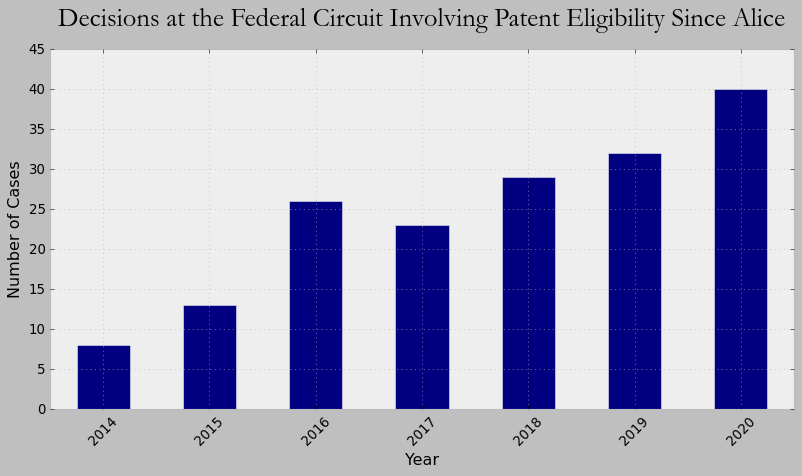

In [167]:
fig = plt.figure()
plt.style.use('bmh')
ax = alice_by_year[('resource_uri', 'count')].plot(
    figsize=(12,6), 
    legend=False, 
    kind="bar", 
    colormap='jet',
    xlabel="Year",
    ylabel="Number of Cases",
)
# Set the title to Comic Sans
ax.set_title("Decisions at the Federal Circuit Involving Patent Eligibility Since Alice", fontname='Garamond', fontsize=24)
#ax = plt.gca()''
ttl = ax.title
ttl.set_position([.5, 1.05])
plt.xticks(rotation=45)
plt.ylim((0, 45))
# ax.set_facecolor("#eeeeee")  
ax.grid(linestyle='dotted')
plt.gcf().subplots_adjust(bottom=0.15)
fig.savefig('test.png')

In [168]:
len(cafc_opinion_df)

7434

In [216]:
patent_cases = cafc_opinion_df[cafc_opinion_df['plain_text'].str.contains('35 U.S.C.')
                              | cafc_opinion_df['plain_text'].str.contains('patent')]

In [217]:
len(patent_cases)

2122

In [176]:
alice_patent_cases = patent_cases[patent_cases['plain_text'].str.contains('Alice Corp.') 
                              | patent_cases['plain_text'].str.contains('134 S. Ct. 2347')
                              | patent_cases['plain_text'].str.contains('573 U.S. 208')]

In [177]:
len(alice_patent_cases)

176

In [178]:
len(alice_cases)

177

In [185]:
alice_cases['case_name']

168              Adaptive Streaming Inc. v. Netflix, Inc.
557                   Fast 101 Pty Ltd. v. Citigroup Inc.
649                            Gree, Inc. v. Supercell Oy
840                  C R Bard Inc. v. Angiodynamics, Inc.
1290                           Tecsec, Inc. v. Adobe Inc.
                              ...                        
7025           Smartgene, Inc. v. Advanced Biological Lab
2483    Accenture Global Services v. Guidewire Softwar...
3696    Sinclair-Allison, Inc. v. Fifth Avenue Physici...
3764                      Ultramercial, Inc. v. Hulu, Llc
4697          Cls Bank International v. Alice Corporation
Name: case_name, Length: 177, dtype: object

In [186]:
alice_patent_cases['case_name']

14                    In Re: Marco Guldenaar Holding B.V.
19         Vehicle Intelligence v. Mercedes-Benz USA, LLC
37                 Content Extraction v. Wells Fargo Bank
52         Glasswall Solutions Limited v. Clearswift Ltd.
117     University of Utah Research v. Ambry Genetics ...
                              ...                        
7014      Core Wireless Licensing v. Lg Electronics, Inc.
7025           Smartgene, Inc. v. Advanced Biological Lab
7057    Mortgage Grader, Inc. v. First Choice Loan Ser...
7079               Trading Technologies Intl v. Cqg, Inc.
7273              Finjan, Inc. v. Blue Coat Systems, Inc.
Name: case_name, Length: 176, dtype: object

In [196]:
trademark_cases= cafc_opinion_df[cafc_opinion_df['plain_text'].str.contains('Trademark')
                              | cafc_opinion_df['plain_text'].str.contains('trademark')]

In [197]:
len(trademark_cases)

1803

In [218]:
patent_cases['date_created'] = pd.to_datetime(patent_cases['date_created'])
patent_cases.sort_values(by="date_created", ascending=False, inplace=True)
patent_cases['date_created'] = patent_cases['date_created'].dt.strftime('%m/%d/%Y')

In [219]:
import json
patent_cases_json = json.loads(patent_cases.to_json(orient='records'))

CAFC_PATENT_CASES = "data/cafc_patent_cases.json"
with open(CAFC_PATENT_CASES, 'w') as outfile:
    json.dump(patent_cases_json, outfile)